In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import losses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [4]:
def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    # mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    # mammo.set_index(keys='refnum', drop=True, inplace=True)

    return mammo

In [5]:
mias = create_mias_dataset('/content/drive/MyDrive/Dataset/Info.txt')
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,None,NaN,NaN,NaN
3,mdb004,D,NORM,None,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,None,NaN,NaN,NaN
326,mdb319,D,NORM,None,NaN,NaN,NaN
327,mdb320,D,NORM,None,NaN,NaN,NaN
328,mdb321,D,NORM,None,NaN,NaN,NaN


In [6]:
# drop nan in severity which indicate norm 
mias.dropna(subset=['severity'], inplace=True)
mias.reset_index(inplace=True)
mias.drop(['index'],axis=1,inplace=True)
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb005,F,CIRC,B,477.0,133.0,30.0
3,mdb010,F,CIRC,B,525.0,425.0,33.0
4,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...
110,mdb274,F,MISC,M,127.0,505.0,123.0
111,mdb290,D,CIRC,B,337.0,353.0,45.0
112,mdb312,F,MISC,B,240.0,263.0,20.0
113,mdb314,F,MISC,B,518.0,191.0,39.0


In [7]:
# make x and y float values
mias.x = mias.x.astype(float)
mias.y = mias.y.astype(float)

In [8]:
def get_crop_coords(image_name):
      '''Returns a tuple with x, y and r'''
      # check scan class to decide on how to crop
      if (np.isnan(mias[mias.refnum == image_name].radius.values[0])):
          radius = 48.0
      else:
          radius = mias[mias.refnum == image_name].radius.values[0]

      if (np.isnan(mias[mias.refnum == image_name].x.values[0])):
          x = float(np.random.randint(500, 513))
      else:
          x = mias[mias.refnum == image_name].x.values[0]
               
      if (np.isnan(mias[mias.refnum == image_name].y.values[0])):
        y = float(np.random.randint(500, 513))
      else:
        y = mias[mias.refnum == image_name].y.values[0]
            
      return (radius, 1024.0-y, x)

In [9]:
# B = 0
# M = 1
lb = LabelEncoder()
mias['severity'] = lb.fit_transform(mias['severity'])
labels= to_categorical(mias['severity'])
labels = np.asarray(labels)

labels.shape

(115, 2)

In [10]:
# images path
path= '/content/drive/MyDrive/Dataset/all-mias/'

# define the every images filepaths in to list
images = []
final_labels=[]

for i in range(len(mias)):
  r,y,x= get_crop_coords(mias.refnum[i])
  image_address= path + mias.refnum[i]+ '.pgm'
  image = Image.open(image_address,mode='r')
  image = image.convert('RGB')
  cropped_img = image.crop((x-r, y-r, x+r, y+r))
  equalized_img = ImageOps.equalize(cropped_img, mask = None)
  final_image= equalized_img.resize((48,48))
  # images.append(np.asarray(final_image))
  for angle in (0, 90, 180, 270):
    rotated = final_image.rotate(angle) # rotated by angle
    mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
    mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)
    images.extend([np.asarray(rotated),np.asarray(mirr_tp),np.asarray(mirr_lr)])
    final_labels.extend([labels[i],labels[i],labels[i]])

In [11]:
images = np.asarray(images)
images.shape

(1380, 48, 48, 3)

In [13]:
final_labels = np.asarray(final_labels)
final_labels.shape

(1380, 2)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(images, final_labels, test_size=0.15, random_state=2021,shuffle=True)

In [15]:
x_train.shape

(1173, 48, 48, 3)

In [16]:
x_test.shape

(207, 48, 48, 3)

In [17]:
base_model = VGG19(input_shape=(48,48,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             40

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=40, batch_size=128,callbacks=[es])

Epoch 1/40
8/8 [==============================] - 17s 624ms/step - loss: 0.7348 - accuracy: 0.6148 - val_loss: 1.4825 - val_accuracy: 0.6080
Epoch 2/40
8/8 [==============================] - 1s 115ms/step - loss: 0.4902 - accuracy: 0.7693 - val_loss: 1.0178 - val_accuracy: 0.7159
Epoch 3/40
8/8 [==============================] - 1s 115ms/step - loss: 0.3806 - accuracy: 0.8425 - val_loss: 0.8446 - val_accuracy: 0.7500
Epoch 4/40
8/8 [==============================] - 1s 116ms/step - loss: 0.3065 - accuracy: 0.8636 - val_loss: 0.8177 - val_accuracy: 0.7727
Epoch 5/40
8/8 [==============================] - 1s 115ms/step - loss: 0.2736 - accuracy: 0.8806 - val_loss: 0.7164 - val_accuracy: 0.8011
Epoch 6/40
8/8 [==============================] - 1s 115ms/step - loss: 0.2536 - accuracy: 0.8957 - val_loss: 0.4801 - val_accuracy: 0.8580
Epoch 7/40
8/8 [==============================] - 1s 107ms/step - loss: 0.2084 - accuracy: 0.9147 - val_loss: 0.4929 - val_accuracy: 0.8409
Epoch 8/40
8/8 [===

In [20]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

7/7 [==============================] - 1s 116ms/step - loss: 0.3811 - accuracy: 0.9324
Test_loss_value = 0.38106027245521545
test_accuracy = 0.9323671460151672


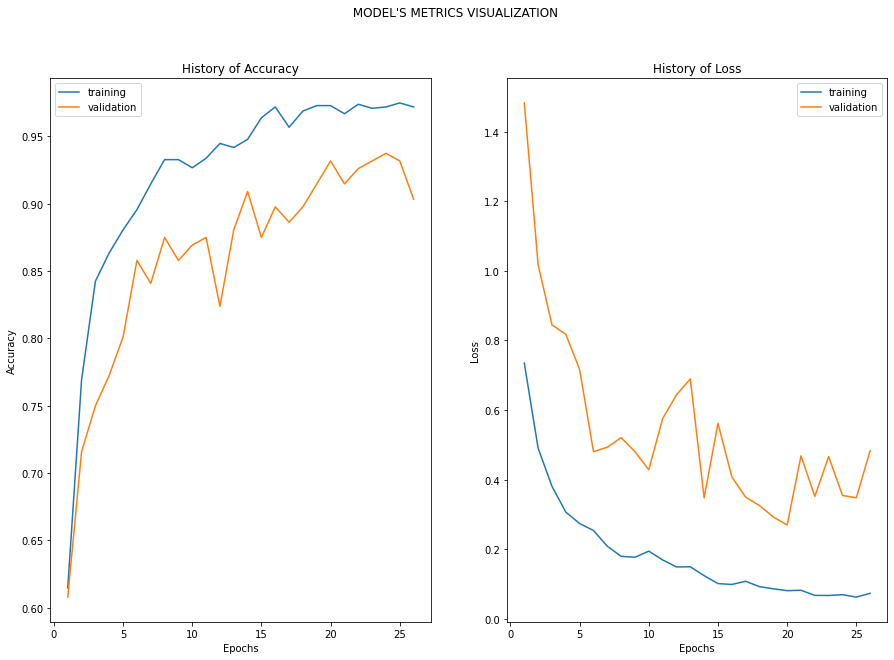

In [21]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [22]:
predictions = model.predict(x_test)
y_pred = [np.argmax(w) for w in predictions]

In [23]:
y_test = [np.argmax(w) for w in y_test]

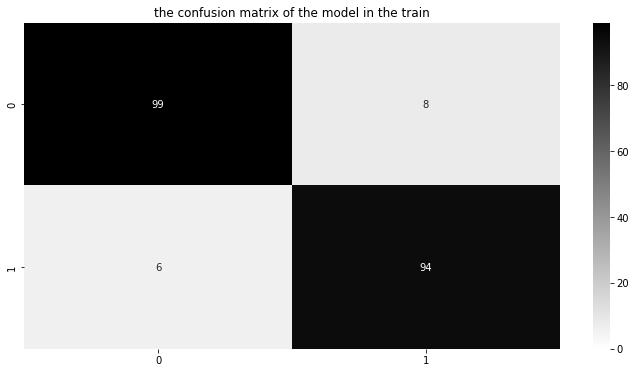

In [24]:
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

In [25]:
label_mapping = {
    1: 'M',
    0: 'B'
}

classification_report_model = classification_report(y_test, y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

           M       0.94      0.93      0.93       107
           B       0.92      0.94      0.93       100

    accuracy                           0.93       207
   macro avg       0.93      0.93      0.93       207
weighted avg       0.93      0.93      0.93       207

